# Popular Data Science Questions
Our goal in this project is to use data from the [Data Science Stack Exchange](https://datascience.stackexchange.com/) to determine what subjects should be addressed in material produced by data science education company. If there are a lot of questions related to a certain subject it is an indication that many find it tricky, thus it might be a good idea to address it in educational material.

## Stack Exchange
__What kind of questions are welcome on this site?__

On DSSE's help center's section on questions , we can read that we should:
- Avoid subjective questions.
- Ask practical questions about Data Science — there are adequate sites for theoretical questions.
- Ask specific questions.
- Make questions relevant to others.

These guidelines should imply the data we can harvest from the site is of creater value to us.

__What, other than questions, does DSSE's home subdivide into?__

On the home page we can see that we have four sections:

- Questions — a list of all questions asked;
- Tags — a list of tags (keywords or labels that categorize questions);
- Users — a list of users;
- Unanswered — a list of unanswered questions;

Tags appear to be something that could be of great help to us in our analysis, as it provides a way to quantify questions based on subjects. This would mean that we rely heavily on tags being accurate and consistently used. From the help center we learn that the site is extensively moderated by the community, which instills some confidence that tags are accurate and that the tagging system could be a great tool for us to use.

__What information is available in each post?__

Looking, just as an example, at this question, some of the information we see is:

For both questions and answers:
- The posts's score;
- The posts's title;
- The posts's author;
- The posts's body;

For questions only:
- How many users have it on their "
- The last time the question as active;
- How many times the question was viewed;
- Related questions;
- The question's tags;

## Stack Exchange Data Explorer
Stack Exchange provides a public data base for each of its websites. Here's a [link](https://data.stackexchange.com/datascience/query/new) to query and explore Data Science Stack Exchange's database. SEDE uses [Transact-SQL](https://en.wikipedia.org/wiki/Transact-SQL).

Looking at the data base, four tables stand out as being potentially relevant for our analysis:
- Posts
- PostTags
- Tags
- TagSynonyms

Exploring the forementioned tables a bit leads us to the conclusion that `Posts` should be our focus. For example, `Tags` includes the very relevant figure of how many time each tag have been used. It does however lack the very important information of when these were acquired. A tag may have been very popular several years ago but for various reason not anymore, thus not a very suitable subject for the education company to produce material for. This information is however present in the `Posts` table, along with multiple other interesting data points.

## Extracting the data
Since we want to focus on relatively recent posts to ensure relevance. Therefore, let's only look at posts from 2019.

The `Posts`-table includes a lot of column, many of which are probably not very useful for our goal. Let's focus on the following, probably most relevant ones:
- Id: An identification number for the post.
- PostTypeId: An identification number for the type of post.
- CreationDate: The date and time of creation of the post.
- Score: The post's score.
- ViewCount: How many times the post was viewed.
- Tags: What tags were used.
- AnswerCount: How many answers the question got (only applicable to question posts).
- FavoriteCount: How many times the question was favored (only applicable to question posts).

With regards to the Post Type we'll focus exclusively on the ones considered *Question* (corresponding to PostTypeId = 1). The rest either are answers (which is not very relevant for our goal) or have to few entries to draw any meaningful conclusions based on this column.

Let's extract data based on the criteria mentioned above using the following query:
``` mysql
SELECT Id, CreationDate,
       Score, ViewCount, Tags,
       AnswerCount, FavoriteCount
  FROM Posts
 WHERE PostTypeId = 1 AND YEAR(CreationDate) = 2019;
```
We stored the extracted data in a csv-file named `SEDE_19.csv`.

## Exploring the data
We continue by importing pandas and reading in the data. Let's also begin initial exploration of the data.

In [1]:
import pandas as pd

SEDE_19 = pd.read_csv('SEDE_19.csv', parse_dates=['CreationDate'])
SEDE_19.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,61806,2019-10-16 07:35:07,0,105,<machine-learning><python>,1,NaN
1,61807,2019-10-16 08:14:28,1,60,<keras><convnet><image-preprocessing>,0,NaN
2,61811,2019-10-16 09:15:08,0,18,<keras><convnet><image-preprocessing>,0,NaN
3,61814,2019-10-16 10:50:19,0,49,<class-imbalance>,2,NaN
4,61815,2019-10-16 11:16:12,1,15,<time-series><clustering><unsupervised-learning>,0,1.0


We instantly notice that `FavoriteCount` have multiple missing values. Before exploring that further, let's look at a summary of all columns to see if this problem is isolated to `FavoriteCount`.

In [2]:
SEDE_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7652 entries, 0 to 7651
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             7652 non-null   int64         
 1   CreationDate   7652 non-null   datetime64[ns]
 2   Score          7652 non-null   int64         
 3   ViewCount      7652 non-null   int64         
 4   Tags           7652 non-null   object        
 5   AnswerCount    7652 non-null   int64         
 6   FavoriteCount  1521 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 418.6+ KB


Apparently, only `FavoriteCount` has missing values, and a lot of them! A missing value on this column probably means that the question was is not present in any users' favorite list, so we can replace the missing values with zero. Let's explore the distribution of values in this column:

In [3]:
SEDE_19['FavoriteCount'].value_counts(dropna=False).sort_index()

0.0      160
1.0      994
2.0      245
3.0       60
4.0       27
5.0       11
6.0        9
7.0        5
8.0        4
11.0       2
12.0       2
15.0       1
16.0       1
NaN     6131
Name: FavoriteCount, dtype: int64

We can with relative certainty say that the missing values should actually have the value 0 as this rhymes with the overall trend of the distribution and seems like an overall reasonable proposition. The fact that we have a few already registered as 0 could be due to some posts at one point being marked as favorite but subsequently unfavored.

Let's decide to commit to this change and then convert that column to integer type. The other columns already have reasonable data types and do not miss any data, thus not requiring further action at this point.

Since the object dtype is a catch-all type, let's see what types are present in the `Tags`-column.

In [4]:
SEDE_19['Tags'].apply(lambda tag: type(tag)).unique()

array([<class 'str'>], dtype=object)

As one might have expected all the entries were strings for the tags-column. Since multiple tags are present in every entry, we'll have to figure out how to handle this. Let's for now keep them as a list.

## Cleaning the data
Let's begin by executing the changes to the `FavoriteCount`-column:

In [5]:
SEDE_19.fillna(value={"FavoriteCount": 0}, inplace=True)
SEDE_19["FavoriteCount"] = SEDE_19["FavoriteCount"].astype(int)
SEDE_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7652 entries, 0 to 7651
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             7652 non-null   int64         
 1   CreationDate   7652 non-null   datetime64[ns]
 2   Score          7652 non-null   int64         
 3   ViewCount      7652 non-null   int64         
 4   Tags           7652 non-null   object        
 5   AnswerCount    7652 non-null   int64         
 6   FavoriteCount  7652 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(4), object(1)
memory usage: 388.7+ KB


Let's also convert our tags-values to regular lists. We first remove the initial '<' and the final '>' and then split on '><' to extract lists.

In [6]:
SEDE_19["Tags"] = SEDE_19["Tags"].str.replace("^<", "").str.replace(">$", "").str.split("><")
SEDE_19.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,61806,2019-10-16 07:35:07,0,105,"[machine-learning, python]",1,0
1,61807,2019-10-16 08:14:28,1,60,"[keras, convnet, image-preprocessing]",0,0
2,61811,2019-10-16 09:15:08,0,18,"[keras, convnet, image-preprocessing]",0,0
3,61814,2019-10-16 10:50:19,0,49,[class-imbalance],2,0
4,61815,2019-10-16 11:16:12,1,15,"[time-series, clustering, unsupervised-learning]",0,1


## Most Used and Most Viewed
We now focus on determining the most popular tags. We'll do so by considering two different popularity proxies: for each tag we'll count how many times the tag was used, and how many times a question with that tag was viewed.

We could take into account the score, or whether or not a question is part of someone's favorite questions. These are all reasonable options to investigate; but we'll limit the focus of our research to counts and views for now.

Let's count how many times each tag was used and the visualize it:

In [7]:
tag_dict = {}
def count_tags(tag_list):
    for i in tag_list:
        if i in tag_dict:
            tag_dict[i] += 1
        else:
            tag_dict[i] = 1


            
SEDE_19['Tags'].apply(count_tags)

tag_count = pd.DataFrame.from_dict(tag_dict, orient="index")
tag_count.rename(columns={0: "count"}, inplace=True)
tag_count.head()

,count
machine-learning,2363
python,1600
keras,811
convnet,94
image-preprocessing,57


Let's now focus our attention to the top most used tags. In this instance we'll go with the top 20, but other arrangements can be just as legitimate. This should be enough to fulfill our goal to a reasonable extent.

In [8]:
most_used = tag_count.sort_values(by='count', ascending=False).head(20)
most_used

,count
machine-learning,2363
python,1600
deep-learning,1025
neural-network,925
keras,811
classification,617
tensorflow,489
scikit-learn,485
nlp,435
cnn,416


Let's visualize the tag count:

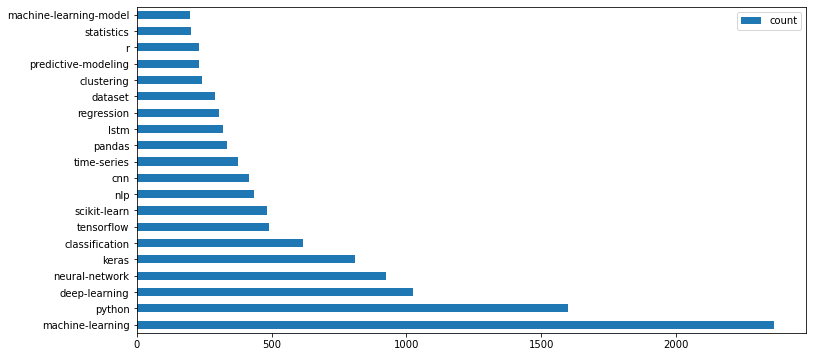

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

most_used.plot(kind='barh', figsize=(12,6))
plt.show()

Many of the tags are very broad in their nature, such as 'Python', thus perhaps not very useful. We'll look into that i greater detail later.

Now let's turn our attention to how many times each tag was viewed. We'll use pandas [DataFrame.iterrows()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html#pandas.DataFrame.iterrows) to iterate over the rows.

In [10]:
tag_views = {}

for index, row in SEDE_19.iterrows():
    for i in row['Tags']:
        if i in tag_views:
            tag_views[i] += row['ViewCount']
        else:
            tag_views[i] = row['ViewCount']
            
most_viewed = pd.DataFrame.from_dict(tag_views, orient='index').rename(columns={0: 'views'})\
.sort_values(by='views', ascending=False).head(20)
most_viewed

,views
python,1317093
machine-learning,849124
keras,592809
pandas,588788
deep-learning,495157
neural-network,415113
scikit-learn,308865
tensorflow,284345
classification,231547
dataframe,226560


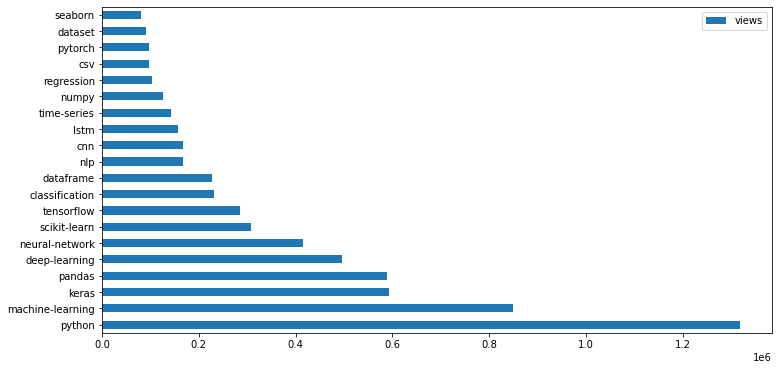

In [11]:
most_viewed.plot(kind='barh', figsize=(12,6))

We notice a lot of similarities between the top viewed and top posted tags. There seem to be correlation between the two, which is not very surprising.

## Relationship between tags
Let's left- respectively right-join the previously produced tables to see what entries exists in one table and not the other and vice versa.

In [12]:
pd.merge(left=most_used, right=most_viewed, how='left', left_index=True, right_index=True)

,count,views
machine-learning,2363,849124.0
python,1600,1317093.0
deep-learning,1025,495157.0
neural-network,925,415113.0
keras,811,592809.0
classification,617,231547.0
tensorflow,489,284345.0
scikit-learn,485,308865.0
nlp,435,168280.0
cnn,416,166792.0


In [13]:
pd.merge(left=most_used, right=most_viewed, how='right', left_index=True, right_index=True)

,count,views
python,1600.0,1317093
machine-learning,2363.0,849124
keras,811.0,592809
pandas,334.0,588788
deep-learning,1025.0,495157
neural-network,925.0,415113
scikit-learn,485.0,308865
tensorflow,489.0,284345
classification,617.0,231547
dataframe,NaN,226560


As we can see there are a couple of instances where a tag exists in on table and not in the other. However, these instances seem to be located closer to the bottom of the lists, which one might expect since as there is bound to be a greater sample variance among those entries.

__Tags in `most_used` but not in `most_viewed`__:
- clustering
- predictive-modeling
- statistics
- machine-learning-model

__Tags in `most_viewed` but not in `most_used`__:
- dataframe
- numpy
- csv
- pytorch
- seaborn

Anther point worth noting is that several of the tags are more or less related to each other. For instance, numpy is a python-library and as a result, when talking about numpy we are implicitly also talking about python.

There are several ways to look at the question of relations between pairs of tags. One possibility is two make some sort of a representation on a 2D-grid in which the top 20 most used tags make up both the X- and Y-axis. Each square on this grid will represent a relation between two tags. The grid can then be colored according to often pairs of tags co-exist.

Let's begin by just creating the grid numericly:

In [14]:
all_tags = list(tag_count.index)
associations = pd.DataFrame(index=all_tags, columns=all_tags)

associations.fillna(0, inplace=True)

for tags in SEDE_19["Tags"]:
    associations.loc[tags, tags] += 1
    
relations_most_used = associations.loc[most_used.index, most_used.index]
relations_most_used

,machine-learning,python,deep-learning,neural-network,keras,classification,tensorflow,scikit-learn,nlp,cnn,time-series,pandas,lstm,regression,dataset,clustering,predictive-modeling,r,statistics,machine-learning-model
machine-learning,2363,445,365,326,172,235,87,169,101,104,113,60,50,111,87,57,108,54,81,124
python,445,1600,130,124,241,88,136,211,66,51,81,231,48,55,48,44,30,21,32,34
deep-learning,365,130,1025,271,219,52,115,13,61,136,33,1,78,20,23,2,26,4,11,16
neural-network,326,124,271,925,216,58,95,21,23,102,29,1,56,42,17,5,9,8,10,9
keras,172,241,219,216,811,53,227,27,20,102,41,3,111,28,9,0,11,10,1,13
classification,235,88,52,58,53,617,18,42,33,15,21,3,15,31,23,11,25,8,16,21
tensorflow,87,136,115,95,227,18,489,9,10,46,8,3,30,8,8,0,4,1,0,8
scikit-learn,169,211,13,21,27,42,9,485,12,0,9,35,1,37,6,22,12,1,4,16
nlp,101,66,61,23,20,33,10,12,435,7,0,3,16,2,10,9,0,3,3,4
cnn,104,51,136,102,102,15,46,0,7,416,7,1,20,4,9,0,5,2,1,3


Let's make this a little more intuitive to look at:

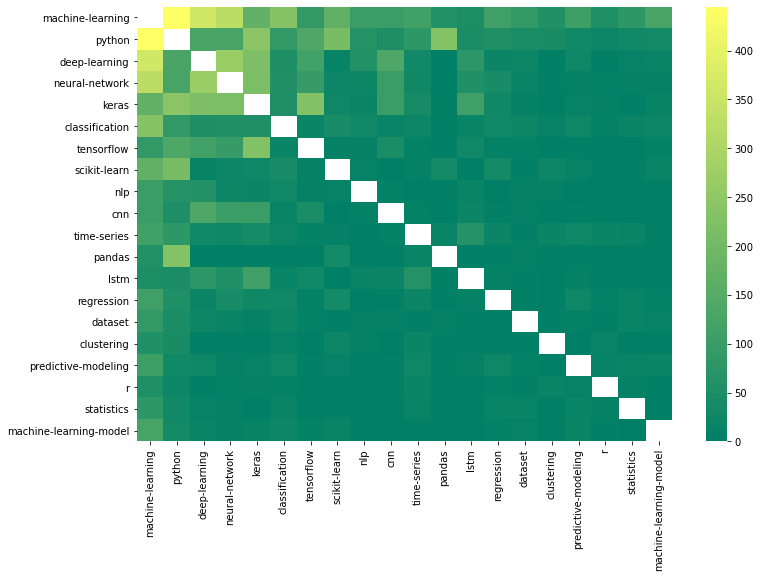

In [17]:
import seaborn as sns
import numpy as np

for i in range(relations_most_used.shape[0]):
    relations_most_used.iloc[i,i] = np.NaN

plt.figure(figsize=(12,8))
sns.heatmap(relations_most_used, cmap="summer", annot=False)

Looking at it in this absolute way is in many ways suboptimal. The most used tags are also the most "related" ones, which could just be a result of the tags being used a lot. We do however get some indication of how related some tags are. For example, neural networks and python don't seem to be very related while neural networks and machine learning seem to be quite related, which is to be expected from the nature of these tags.

Another problem with this approach is that it doesn't recognize relations of sets of tags. A combination of certain tags may be very related to a specific tag, while they are not individually.

So how do we attack both these problems? There is a powerful data mining technique that allows us to handle this: association rules. Association rules allow us to analytically spot relations like "people who purchase milk, also purchase eggs". Moreover, we can also measure how strong this relations are on several fronts: how common the relation is, how strong it is, and how independent the components of the relationship are. At this point in the programme this project is a part of, such techniques have not yet been introduced. Thus, it won't be explored further as of now.

## Domain knowledge
Another way to look at the issue is by using our domain knowledge. We noticed that the most used tags are also the most viewed. From the top 10 tags in terms of views and count the following were present in both: `python`, `machine-learning`, `deep-learning`, `neural-network`, `keras`, `tensorflow`, `classification`, `scikit-learn`.
We can use knowledge about the subjects these tags represent to determine how related they are.

For this, the [DSSE tag page](https://datascience.stackexchange.com/tags) can be of use, as well as many other sources.

`Keras`, `scikit-learn`, `TensorFlow` are all Python libraries that can be used to implement deep learning techniques (a form of neural network).

We can see that essentially all tags are related to machine learning (with a strong tilt towards deep learning) and/or python. Therefore, it could be a good idea to consider deep learning material, implemented using python and its relevant libraries.

## Just a fad?
Before we officially make our recommendation, it would be nice to solidy our findings with additional proof. More specifically, one thing that comes to mind is "Is deep learning just a fad?" Ideally, the content we decide to create will be the most useful for as long as possible. Could interest in deep learning be slowing down?

To examine this, we need to lift our scope from only looking at 2019 and examining a longer period. This data is retrievable from SEDE similar to the way we got the 2019 data, using the following query:
``` mysql
SELECT Id, CreationDate, Tags
  FROM posts
 WHERE PostTypeId = 1;
```

We will track the interest in deep learning across time and:
- Count how many deep learning questions are asked per time period.
- The total amount of questions per time period.
- How many deep learning questions there are relative to the total amount of questions per time period.

Let's read in our new data set:

In [18]:
all_questions = pd.read_csv('all_questions.csv', parse_dates=['CreationDate'])
all_questions.head()

,Id,CreationDate,Tags
0,71360,2020-03-28 15:07:26,<machine-learning><scikit-learn><svm><features>
1,71362,2020-03-28 15:12:00,<deep-learning><keras><image-classification>
2,71368,2020-03-28 16:55:44,<python><matplotlib><mathematics>
3,71372,2020-03-28 18:02:54,<deep-learning><computer-vision>
4,71375,2020-03-28 18:59:09,<word-embeddings><embeddings>


We'll begin by doing the same transformations as earlier:

In [19]:
all_questions['Tags'] = all_questions['Tags'].str.replace("^<", "").str.replace(">$", "").str.split("><")
all_questions.head()

,Id,CreationDate,Tags
0,71360,2020-03-28 15:07:26,"[machine-learning, scikit-learn, svm, features]"
1,71362,2020-03-28 15:12:00,"[deep-learning, keras, image-classification]"
2,71368,2020-03-28 16:55:44,"[python, matplotlib, mathematics]"
3,71372,2020-03-28 18:02:54,"[deep-learning, computer-vision]"
4,71375,2020-03-28 18:59:09,"[word-embeddings, embeddings]"


We look at all tags in `most_used` and research which ones are related to deep-learning and come up with the following list:
["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"].

We consider questions including one of these tags as a deep-learning question.

Let's create a new function, `is_DL`, that takes a list of tags and returns 1 if one of tags is contained in the list above, thus is related to deep-learning.

In [25]:
DL_tags = set(["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"])

def is_DL(tags):
    for tag in tags:
        if tag in DL_tags:
            return 1
    return 0

Let's now create a new column in `all_questions` called `DL_status`, keeping track of whether or not the question is related to deep-learning. We will fill the values using the `is_DL` function created above.

In [27]:
all_questions['DL_status'] = all_questions['Tags'].apply(is_DL)
all_questions.head()

,Id,CreationDate,Tags,DL_status
0,71360,2020-03-28 15:07:26,"[machine-learning, scikit-learn, svm, features]",1
1,71362,2020-03-28 15:12:00,"[deep-learning, keras, image-classification]",1
2,71368,2020-03-28 16:55:44,"[python, matplotlib, mathematics]",0
3,71372,2020-03-28 18:02:54,"[deep-learning, computer-vision]",1
4,71375,2020-03-28 18:59:09,"[word-embeddings, embeddings]",0


Seems to be working fine!

To make it easier to draw conclusions we will group the data in suitable periods to get a decent comparable sample. We'll go with quarters.

We don't have all data for the 3rd quarter in 2020, so let's get rid of those entries:

In [29]:
import datetime as dt

all_questions = all_questions[all_questions['CreationDate'] < dt.datetime(2020,7,1)]
all_questions['CreationDate'].max()

Timestamp('2020-06-30 22:46:59')

With that done, let's create a function that takes a date and return its corresponding quarter in the form of "19Q1" and similar.

In [45]:
import math

def get_quarter(date):
    y = str(date.year)[-2:]
    m = date.month
    q = math.floor((m - 1) / 3) + 1
    return "{}Q{}".format(y, q)

Let's now create a new column, `quarter`, containing the quarter a post belongs to, using the `get_quarter`-function.

In [46]:
all_questions['quarter'] = all_questions['CreationDate'].apply(get_quarter)
all_questions['quarter'].value_counts()

20Q2    2408
20Q1    2113
19Q3    2048
19Q4    2012
19Q2    1830
19Q1    1762
18Q3    1483
18Q2    1442
18Q4    1290
18Q1    1219
17Q4     895
17Q3     712
17Q1     696
17Q2     645
16Q3     584
16Q4     527
16Q2     517
16Q1     516
15Q4     382
15Q3     311
15Q2     284
14Q4     214
15Q1     190
14Q3     188
14Q2     157
Name: quarter, dtype: int64

With that done, let's now group by quarter and attempt to answer the following questions:
- How many deep learning questions are asked per quarter?
- What is the total amount of questions per quarter?
- How many deep learning questions there are relative to the total amount of questions per quarter?

In [56]:
q_grouped = all_questions.groupby('quarter').agg({'DL_status': ['size', 'sum']})
q_grouped.columns = ['total_questions', 'DL_questions']
q_grouped['DL_share'] = round(q_grouped['DL_questions']/q_grouped['total_questions'], 3)
q_grouped.reset_index(inplace=True)
q_grouped

,quarter,total_questions,DL_questions,DL_share
0,14Q2,157,9,0.057
1,14Q3,188,13,0.069
2,14Q4,214,21,0.098
3,15Q1,190,18,0.095
4,15Q2,284,28,0.099
5,15Q3,311,45,0.145
6,15Q4,382,66,0.173
7,16Q1,516,110,0.213
8,16Q2,517,109,0.211
9,16Q3,584,161,0.276


What's most interesting is the `DL_share`-column, that shows how large share of the total questions asked in a quarter that are considered deep-learning question, in accordance with the forementioned definition. One have to imagine that this number should be slightly higher since we only take into account the most popular DL-tags but there most likely are more DL tags with less use that could contribute somewhat.

Let's visualize this to try and get a sense of what we're working with:

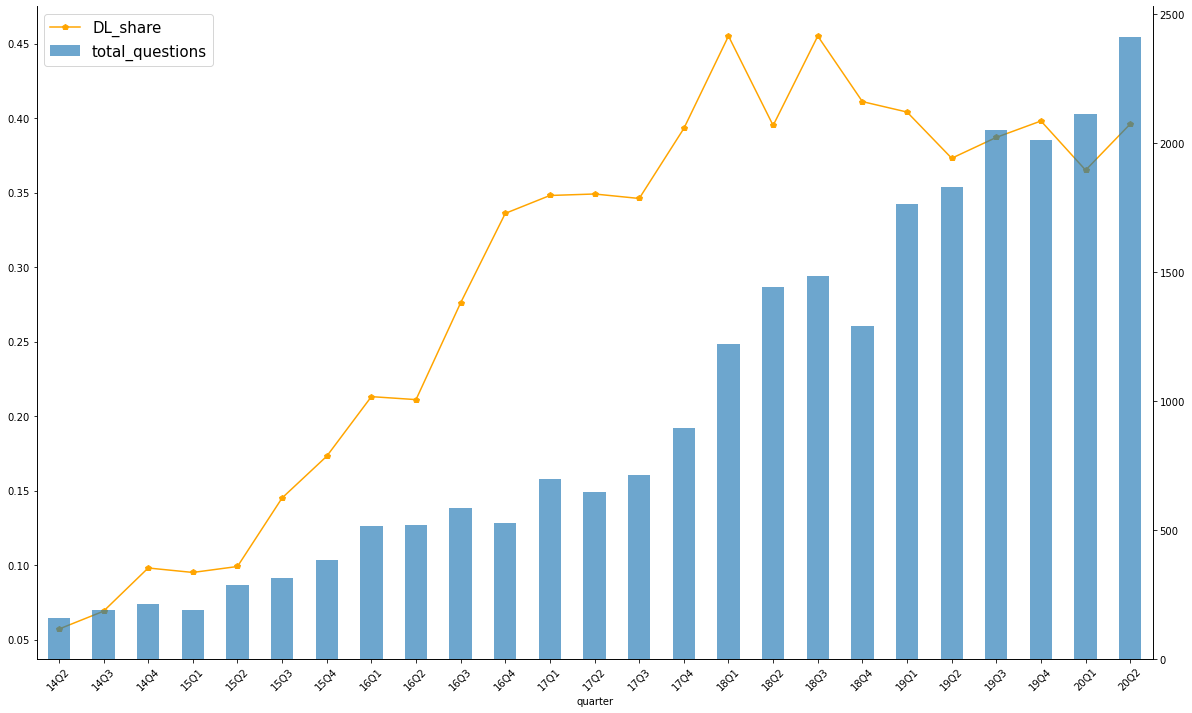

In [86]:
ax1 = q_grouped.plot(kind='line', x='quarter', y='DL_share', color='orange', marker='p', figsize=(20,12))
ax2 = q_grouped.plot(kind='bar', x='quarter', y='total_questions', ax=ax1, secondary_y=True, rot=45, alpha=0.65)

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 15})

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

As we can see, the total question have steadily increased over the time period. This could indicate that there is an increasing interest in data science in general, which is positive for our business.

Regarding the share of deep-learning related questions, we've seen an exploding interest topping out at around 45% in 18Q1. Since then, the percentage seem to have plateaued around a high level. This means the the interest in the field doesn't seem to be increasing anymore, but it has stabilized at a very high level.

This positively supports our suggestion that deep-learning material (especially such with python focus, since the tags indicated a tilt towards that) could be a very good idea for the data science education company to produce. Therefore, this becomes our official recommendation.